In [4]:
!pip install pandas numpy matplotlib statsmodels pmdarima scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
from sklearn.metrics import mean_squared_error

def get_mean_squared_error(ground_truth, pred):
  return np.square(np.subtract(ground_truth, pred)).mean()

def get_root_mean_squared_error(ground_truth, pred):
  return np.sqrt(get_mean_squared_error(ground_truth, pred))

def get_mean_absolute_error(ground_truth, pred):
  return np.abs(ground_truth, pred).mean()

def get_mean_absolute_percentage_error(ground_truth, pred):
  return np.abs((ground_truth - pred) / pred).mean() * 100


def get_average_relative_error(ground_truth, pred):
  mean = np.mean(ground_truth)
  sup = np.square(np.subtract(ground_truth, pred)).sum()
  inf = np.square(np.subtract(ground_truth, mean)).sum()

  return sup / inf

def get_metrics(ground_truth, pred):
  mse = get_mean_squared_error(ground_truth, pred)
  rmse = get_root_mean_squared_error(ground_truth, pred)
  mae = get_mean_absolute_error(ground_truth, pred)
  mape = get_mean_absolute_percentage_error(ground_truth, pred)
  avr = get_average_relative_error(ground_truth, pred)

  return {"mse": mse,
          "rmse": rmse,
          "mae": mae,
          "mape": mape,
          "avr": avr}

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/arthurwanderley/Series_Temporais/refs/heads/main/Metro_Interstate_Traffic_Volume.csv')
# Converter coluna de data (se houver) e definir como índice
df['date_time'] = pd.to_datetime(df['date_time'])

<Axes: >

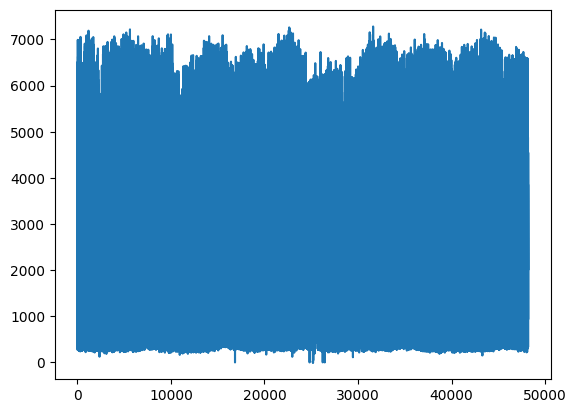

In [11]:
df['traffic_volume'].plot()

In [12]:
df['traffic_volume'] = df['traffic_volume'].astype(float)

In [13]:
result_kpss = kpss(df['traffic_volume'], regression='c', nlags='auto')
print(f'Teste KPSS: p-value = {result_kpss[1]}')

Teste KPSS: p-value = 0.1


C:\Users\Administrador\AppData\Local\Temp\ipykernel_27268\415916853.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(df['traffic_volume'], regression='c', nlags='auto')


In [14]:
#Como a série já é estacionária:
series = df['traffic_volume']

In [15]:
# Dividir em treino e teste
size_test = len(series) * 0.8
treino = series[:int(size_test)]
teste = series[int(size_test):]

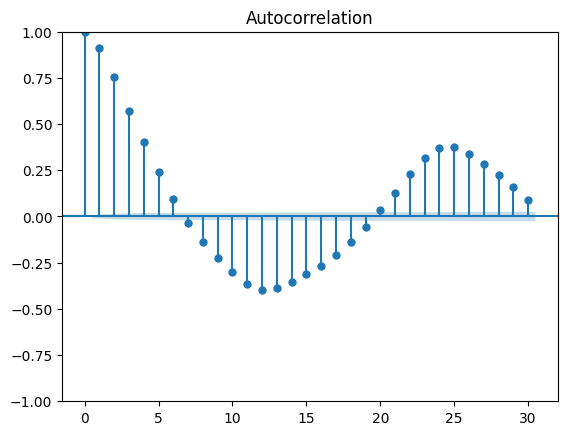

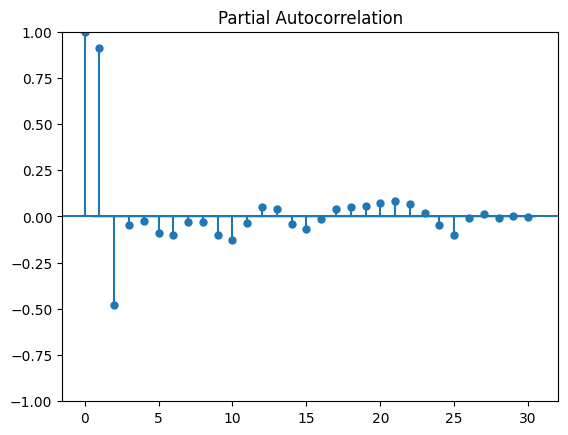

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['traffic_volume'], lags = 30)
plot_pacf(df['traffic_volume'], lags = 30)
plt.show()

In [22]:
# Modelo AR
model_ar = AutoReg(treino, lags=7).fit()
previsao_ar = model_ar.predict(start=len(treino), end=len(treino) + len(teste) - 1)
get_metrics(teste.values.squeeze(), previsao_ar.values)

{'mse': np.float64(3871794.1520354785),
 'rmse': np.float64(1967.687513818055),
 'mae': np.float64(3255.3302561974897),
 'mape': np.float64(0.0),
 'avr': np.float64(0.0)}

In [25]:
# Modelo MA
model_ma = ARIMA(treino, order=(0, 0, 3)).fit()
previsao_ma = model_ma.forecast(steps=len(teste))
get_metrics(teste.values.squeeze(), previsao_ma.values)

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'mse': np.float64(3871644.3246464976),
 'rmse': np.float64(1967.649441502855),
 'mae': np.float64(3255.3302561974897),
 'mape': np.float64(0.0),
 'avr': np.float64(0.0)}

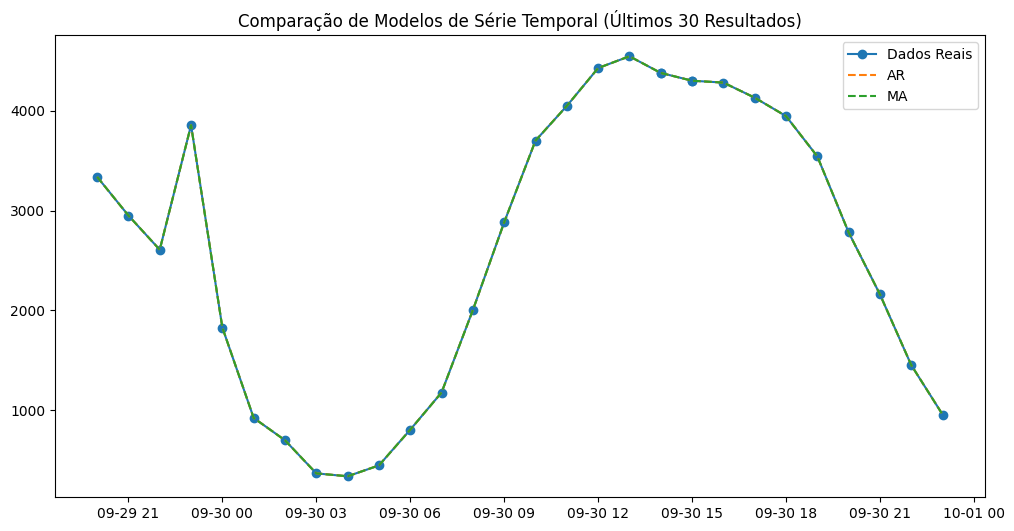

In [39]:
# Plotando os últimos 30 resultados
plt.figure(figsize=(12, 6))
plt.plot(df['date_time'].iloc[-30:], teste.iloc[-30:], label='Dados Reais', marker='o')
#plt.plot(df['Data'].iloc[-30:], previsao_arima[-30:], label='ARIMA', linestyle='dashed')
#plt.plot(df['Data'].iloc[-30:], previsao_sarima[-30:], label='SARIMA', linestyle='dashed')
plt.plot(df['date_time'].iloc[-30:], previsao_ar[-30:], label='AR', linestyle='dashed')
plt.plot(df['date_time'].iloc[-30:], previsao_ma[-30:], label='MA', linestyle='dashed')
plt.legend()
plt.title('Comparação de Modelos de Série Temporal (Últimos 30 Resultados)')
plt.show()

O desempenho tanto do modelo AR quanto do modelo MA foram muito satisfatórios.